In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.datasets import  make_classification


/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_raw = pd.read_csv("~/buypoints_20181209_2000.tsv", sep="\t")
# df_raw = pd.read_csv("~/buypoints.tsv", sep="\t")


features = ["average_inner_amplitude", 
            "average_outer_amplitude", 
            "average_turn_rate", 
            "increase_before_fallback", 
            "max_decrease",  
            "pb_height", 
            "pe_height", 
            "profit_growth", 
            "sma10_120", 
            "sma10_250", 
            "sma120_250", 
            "sma50_120", 
            "variance", 
            "volume_ratio",
            "adjust_period",
            "business_growth",
            "pe",
            "pb",
            "mkt_cap",
            "new_high_days",
            "days_with_lower_price",
            "days_from_bottom",
            "roe",
            "eps",
            "close_sma50",
            "close_sma250",
            "eps_growth"
           ]
target = ["target"]

# add filter here， like pe > 0
# 1. only use end_date <= half year before
now = datetime.now()
half_year = now - timedelta(days=120)
strx =  half_year.strftime("%Y-%m-%d")
df_raw = df_raw[df_raw["end_date"] < strx]


In [3]:
X = df_raw[features]
y = df_raw[target]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 88)


In [4]:
# regression 
# gbm = lgb.LGBMRegressor(objective='regression',num_leaves=31,learning_rate=0.05,n_estimators=100)
# gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)], eval_metric='l2')
# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
 

In [5]:
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import average_precision_score
# import matplotlib.pyplot as plt

# print(len(y_test))
# print(len(y_pred))
# average_precision = average_precision_score(y_test, y_pred)

# precision, recall, _ = precision_recall_curve(y_test, y_pred)

# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, step='post', alpha=0.2,
#                  color='g')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))
# plt.show()

In [6]:
# try classification

from lightgbm import LGBMClassifier,LGBMModel
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix, average_precision_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import sklearn


In [7]:
#default initial parameters for feature selection
lgb_model = LGBMClassifier(boosting_type='gbdt',
                      objective='binary',
                      max_depth=7,
                      learning_rate=0.1,
                      n_estimators=150,
                      min_child_samples=15,
                     silent=False)

# Initialize CV and evaluation objects
kfold = KFold(n_splits=4)

feature_selector = RFECV(lgb_model, cv=kfold, verbose=1, scoring='average_precision')
feature_selector.fit(X_train, y_train)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.


RFECV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
   estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=7,
        min_child_samples=15, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=150, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
   n_jobs=1, scoring='average_precision', step=1, verbose=1)

In [8]:
# Mask with selected features
selected_feature_mask = feature_selector.get_support(indices=True)
selected_features = X_train[features].iloc[:, selected_feature_mask].columns.values
deleted_features = list(set(features) - set(selected_features))

print("Selected features: \n{}\n".format(selected_features))
print("Deleted features: \n{}\n".format(deleted_features))


# Now we can drop the features deemed bad by the model
X_train_filtered = X_train.drop(deleted_features, axis=1)
X_test_filtered = X_test.drop(deleted_features, axis=1)


Selected features: 
['average_inner_amplitude' 'average_outer_amplitude' 'average_turn_rate'
 'max_decrease' 'pb_height' 'pe_height' 'profit_growth' 'sma10_120'
 'sma10_250' 'sma120_250' 'sma50_120' 'variance' 'volume_ratio'
 'adjust_period' 'business_growth' 'pe' 'pb' 'mkt_cap' 'new_high_days'
 'days_with_lower_price' 'days_from_bottom' 'roe' 'eps' 'close_sma50'
 'eps_growth']

Deleted features: 
['increase_before_fallback', 'close_sma250']



过拟合的解决方案有：
1. 减小learning rate
2. feature selection,减少feature
3. 减少树的数量
4. 控制min data in leaf
5. 添加正则项

In [10]:
from sklearn.model_selection import GroupKFold, GridSearchCV

param_grid = {'max_depth': [5, 6, 7], 
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [50, 100, 150],
              'min_data_in_leaf':  [10, 15, 20, 31],
             }
 
kfold = KFold(n_splits=4)

gs = GridSearchCV(lgb_model, param_grid, scoring='average_precision', cv=kfold, refit=True)

gs.fit(X_train_filtered, y_train.values.ravel(), verbose=100)
final_model = gs.best_estimator_

final_model._Booster.save_model("fallback_new_hight_gbdt_model.txt")


print(y_train.shape)
print("Best parameters: ", gs.best_params_)



(28197, 1)
Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'min_data_in_leaf': 15, 'n_estimators': 150}


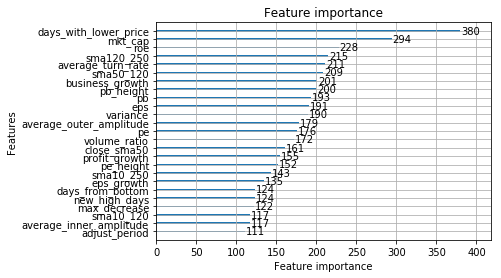

In [11]:
import lightgbm
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 16))
ax = lightgbm.plot_importance(final_model)

plt.show()

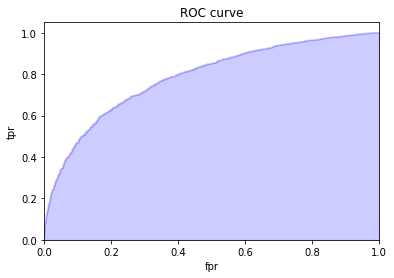

fpr=0.0002 tpr=0.0036 threshold=0.9170
fpr=0.0202 tpr=0.2136 threshold=0.6705
fpr=0.0402 tpr=0.2989 threshold=0.5943
fpr=0.0603 tpr=0.3710 threshold=0.5376
fpr=0.0803 tpr=0.4209 threshold=0.4994
fpr=0.1007 tpr=0.4694 threshold=0.4617
fpr=0.1207 tpr=0.5079 threshold=0.4343
fpr=0.1410 tpr=0.5451 threshold=0.4095
fpr=0.1610 tpr=0.5814 threshold=0.3834
fpr=0.1831 tpr=0.6095 threshold=0.3613


In [12]:
from sklearn.metrics import roc_curve
for mod,X_t in [(final_model, X_test_filtered)]:
    preds = mod.predict_proba(X_t)
    fpr, tpr, thresholds = roc_curve(y_test, preds[:,1], pos_label=1)
    
    plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')

    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('ROC curve')
    plt.show()
    
step = 0.02
last = -step
for i in range(len(fpr)):
    if fpr[i] - last > step and fpr[i] < 0.2:
        last = fpr[i]
        print("fpr=%.4f tpr=%.4f threshold=%.4f" % (fpr[i], tpr[i], thresholds[i]))

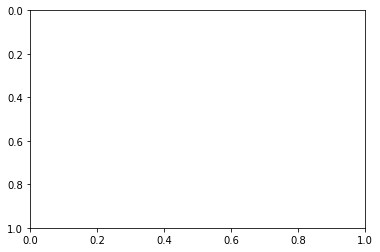

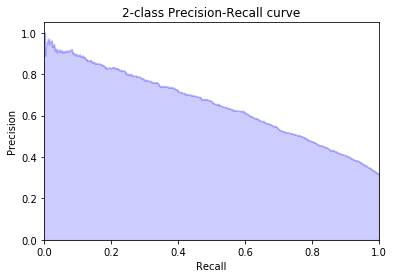

r=0.6141 p=0.60 f1=0.61 threshold=0.3581
r=0.6023 p=0.61 f1=0.61 threshold=0.3675
r=0.5959 p=0.62 f1=0.61 threshold=0.3738
r=0.5578 p=0.63 f1=0.59 threshold=0.3988
r=0.5438 p=0.64 f1=0.59 threshold=0.4109
r=0.5229 p=0.65 f1=0.58 threshold=0.4267
r=0.5061 p=0.66 f1=0.57 threshold=0.4363
r=0.5011 p=0.67 f1=0.57 threshold=0.4422
r=0.4694 p=0.68 f1=0.56 threshold=0.4629
r=0.4612 p=0.69 f1=0.55 threshold=0.4707
r=0.4376 p=0.70 f1=0.54 threshold=0.4885
r=0.4113 p=0.71 f1=0.52 threshold=0.5086
r=0.4000 p=0.72 f1=0.51 threshold=0.5170
r=0.3878 p=0.73 f1=0.51 threshold=0.5258
r=0.3637 p=0.74 f1=0.49 threshold=0.5424
r=0.3433 p=0.75 f1=0.47 threshold=0.5582
r=0.3238 p=0.76 f1=0.45 threshold=0.5735
r=0.3079 p=0.77 f1=0.44 threshold=0.5893
r=0.2930 p=0.78 f1=0.43 threshold=0.6011
r=0.2766 p=0.79 f1=0.41 threshold=0.6169
r=0.2472 p=0.80 f1=0.38 threshold=0.6385
r=0.2426 p=0.81 f1=0.37 threshold=0.6448
r=0.2299 p=0.82 f1=0.36 threshold=0.6557
r=0.2132 p=0.83 f1=0.34 threshold=0.6712
r=0.1791 p=0.84 

In [21]:

import math
def max_recall_for_precision(data, scores, pos_label, min_pr):
#       """Find precision, recall, threshold which is >= min_pr and maximizes recall"""
    if pos_label==0:
        pr, rec, thresh = precision_recall_curve(1 - data, 1 - scores, pos_label=1)
        thresh = 1 - thresh #convert threshold back to P(nondefect) score space
    else:
        pr, rec, thresh = precision_recall_curve(data, scores, pos_label=1)
    values = [(r, p, t) for p, r, t in zip(pr, rec, thresh) if p >= min_pr]
    if len(values) >=1:
        r, p, t = max(values)
        return p, r, t
    return None, None, None


def plot_prcurve(y_test, y_pred):
    plt.figure(figsize=(6, 4))
    precision,recall,threshold = precision_recall_curve(y_test, y_pred)
    plt.step(recall, precision, color='b', alpha=0.1, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')
    plt.show()

for mod,X_t in [(final_model, X_test_filtered)]:
    preds = mod.predict_proba(X_t)
    plot_prcurve(y_test, preds[:,1])

    for min_pr in range(60, 90, 1):
        min_pr = min_pr / 100.0
        p,r,t = max_recall_for_precision(y_test, preds[:,1], 1, min_pr)
        f1 = 2 * min_pr * r / (min_pr + r)
        print("r=%.4f p=%.2f f1=%.2f threshold=%.4f" % (r, min_pr, f1, t))

    for score in ['average_precision']:
        evaluator = sklearn.metrics.get_scorer(score)
        score_val = evaluator(mod, X_t, y_test)
        print(score, score_val)

(28197, 25)
(28197, 1)


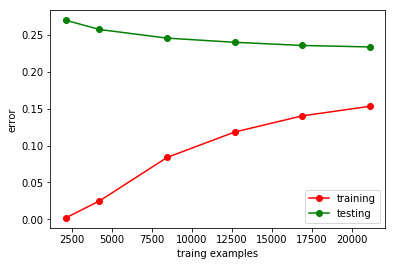

In [14]:
from sklearn.model_selection import learning_curve
print(X_train_filtered.shape)
print(y_train.shape)

train_sizes,train_score,test_score = learning_curve(
    final_model,
    X_train_filtered.values,
    y_train.values.ravel(),
    train_sizes=[0.1,0.2,0.4,0.6,0.8,1],
    cv=4,
    scoring='accuracy')

train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

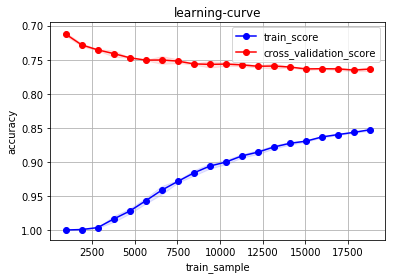

midpoint 0.807607319842 diff 0.0934115291861


(0.80760731984222245, 0.093411529186114617)

In [15]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=1, title = "learning-curve", train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose, scoring='accuracy')
 
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
 
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"train_sample")
        plt.ylabel(u"accuracy")
        plt.gca().invert_yaxis()
        plt.grid()
 
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"train_score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"cross_validation_score")
 
        plt.legend(loc="best")
 
        plt.draw()
        plt.show()
        plt.gca().invert_yaxis()
 
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    print("midpoint", midpoint, "diff", diff)
    return midpoint, diff

plot_learning_curve(
    final_model,
    X_train_filtered.values,
    y_train.values.ravel()
)

In [25]:
# 测试熟悉的股票预测情况
df =  pd.read_csv("~/buypoints.tsv", sep="\t")

one_stock = df_raw[df_raw["code"]==761]
one_stock_X = one_stock[selected_features]

one_stock_y = one_stock[target]


one_stock_predict = final_model.predict(one_stock_X)
one_stock_predict
one_stock['predict'] = one_stock_predict
one_stock[["start_date", "end_date", "gain","target", "predict"]]
 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,start_date,end_date,gain,target,predict
61,2006-04-03,2006-05-22,0.000000,0,0
62,2006-07-05,2006-12-01,1.127922,0,1
63,2006-08-16,2006-10-12,321.612469,1,1
64,2006-11-06,2006-11-30,269.656601,1,1
65,2007-01-24,2007-02-14,155.202146,1,1
66,2007-02-27,2007-03-26,109.359201,1,1
67,2007-08-27,2007-09-17,4.749916,0,0
68,2009-02-17,2009-06-04,57.770897,1,0
69,2010-03-09,2010-10-18,7.413068,0,0
70,2010-08-24,2010-10-15,33.900766,0,0
